In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from ensemble_learning import DecisionTree, entropy, accuracy, compute_gain

In [3]:
def compute_alpha_epsilon(y_true, y_pred, weight):
        
    epsilon = weight[y_true != y_pred].sum()
    
    alpha = 0.5 * np.log((1-epsilon)/(epsilon))
    
    return alpha, epsilon

def compute_next_weight(y_true, y_pred, weight, alpha):
    
    next_weight = (y_true * y_pred).astype(np.float)
    next_weight *= -alpha
    
    next_weight = np.exp(next_weight)
    
    next_weight *= weight
    
    Zt = next_weight.sum()
    
    next_weight /= Zt
    
    return next_weight

In [4]:
class Adaboost(object):
    
    def __init__(self, function=entropy):
        self._function = function
        
    def fit(self, X, y, T=10):
        
        # copy in variables
        self._X = X.copy()
        self._y = y.copy()
        self._T = T
        
        # initialize weigths
        weight = np.ones_like(y) / len(y)
        
        # initialize lists to store variables
        self._stump=[]
        self._alpha=[]
        self._epsilon=[]
        self._key=[]
        
        for i in range(self._T):

            #find decision stump i
            stump = DecisionTree(max_depth=1)
            stump.fit(self._X, self._y, weight=weight)
            self._stump.append(stump)

            # get current predictions
            y_pred = self._stump[i].predict(self._X)

            # find alpha
            alpha, eps = compute_alpha_epsilon(self._y, y_pred, weight)
            self._alpha.append(alpha)
            self._epsilon.append(eps)

            # update weights for next stump
            weight = compute_next_weight(self._y, y_pred, weight, alpha)
            
            # append key for troubleshooting
            self._key.append(self._stump[i]._tree.key)
            
    def predict(self, X, binary=True):
        
        self._Xpred = X.copy()
        
        # initialize all predictions to 0
        y_pred = np.zeros(self._Xpred.shape[0])
        
        # loop over all trees T
        for i in range(self._T):
            
            # get current vot
            pred_t = self._stump[i].predict(self._Xpred).astype(np.float)
            pred_t *= self._alpha[i]
            
            # add to total vote
            y_pred += pred_t
            
        # convert to binary output based on the sign
        if binary:
            y_pred[y_pred < 0] = -1
            y_pred[y_pred >= 0] = 1
            y_pred = y_pred.astype(np.int)
            
        return y_pred

In [9]:
# read data
cols = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
df_train = pd.read_csv('../data/bank/train.csv', names=cols)
df_test = pd.read_csv('../data/bank/test.csv', names=cols)

# process numeric input
medians = df_train.median()

for col in medians.index:
    df_train[col] = df_train[col].apply(lambda x: x > medians[col])
    df_test[col] = df_test[col].apply(lambda x: x > medians[col])
    
# process labels
label_dict={'yes': 1, 'no': -1}
df_train['y'] = df_train['y'].map(label_dict)
df_test['y'] = df_test['y'].map(label_dict)

X_train = df_train.drop(['y'], axis=1).values
y_train = df_train['y'].values

X_test = df_test.drop(['y'], axis=1).values
y_test = df_test['y'].values

In [10]:
model = Adaboost()
model.fit(X_train, y_train, T=20)

In [17]:
iterations = np.arange(0, 51, 5)
iterations[0] = 1

error_train=[]
error_test=[]

for i in iterations:
    model = Adaboost()
    model.fit(X_train, y_train, T=i)
    error_train.append(1 - accuracy(model.predict(X_train), y_train))
    error_test.append(1 - accuracy(model.predict(X_test), y_test))

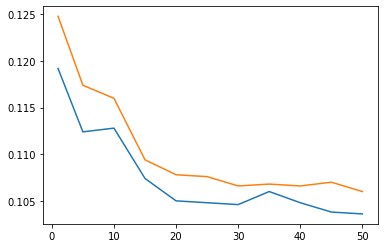

In [19]:
plt.plot(iterations, error_train)
plt.plot(iterations, error_test)
plt.show()